In [4]:
suppressMessages(library(dplyr))
library(ggplot2)
suppressMessages(library(BoutrosLab.plotting.general))
library(rhdf5)
library(ggpubr)
library(repr)
# Change plot size to BIG
options(repr.plot.width=20, repr.plot.height=10)

In [5]:
data.dir <- "/iblm/netapp/data1/jezhou/crisprQTL"
# alt.mods <- readRDS(file.path(data.dir,"sim_performance_D100_4guides_targeting/alt_ml.rds"))
# null.mods <- readRDS(file.path(data.dir,"sim_performance_D100_4guides_targeting/null_ml.rds"))

alt.coeffs <- read.csv(file.path(data.dir,"sim_performance_D100_4guides_targeting/alt_coeffs.csv"))
null.coeffs <- read.csv(file.path(data.dir,"sim_performance_D100_4guides_targeting/null_coeffs.csv"))

# lrt <- read.csv("../sim_performance_100/lrt_pvals.csv")

In [7]:
fh <- "/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_4guides_x1prob/sim.h5"
h5ls(fh)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,coeffs,H5I_DATASET,COMPOUND,13000
1,/,counts,H5I_DATASET,INTEGER,13000 x 50000
2,/,guides,H5I_GROUP,,
3,/guides,est_efficiency_D10,H5I_DATASET,FLOAT,4000
4,/guides,est_efficiency_D100,H5I_DATASET,FLOAT,4000
5,/guides,metadata,H5I_DATASET,COMPOUND,4000
6,/guides,one_hot,H5I_DATASET,INTEGER,50000 x 4000
7,/,linear_predictor,H5I_DATASET,FLOAT,13000 x 50000
8,/,mu,H5I_DATASET,FLOAT,13000 x 50000


In [9]:
guides.metadata <- h5read(fh, "guides/metadata")
head(guides.metadata)

,target.gene,efficiency,effect.size
,<int>,<dbl>,<dbl>
1,2336,0.5899184,-3.517179
2,6778,0.7126936,-2.787360
3,11025,0.3789614,-1.638134
4,11117,0.7749960,-2.222696
5,9957,0.6474995,-1.470936
6,3630,0.6870058,-5.032033


In [10]:
nrow(guides.metadata)/length(unique(guides.metadata$target.gene))

[1] 4

# Plot true vs. estimated $\beta_1$

In [7]:
head(alt.coeffs)

,term,estimate,true,gene,targeting
,<chr>,<dbl>,<dbl>,<int>,<lgl>
1,(Intercept),2.569600,2.588415,2336,TRUE
2,guide.eff,-5.603210,-3.517179,2336,TRUE
3,s.score,2.643193,2.618896,2336,TRUE
4,g2m.score,3.208282,3.212864,2336,TRUE
5,percent.mito,5.349914,5.136400,2336,TRUE
6,(Intercept),2.405914,2.407428,6778,TRUE


`geom_smooth()` using formula 'y ~ x'



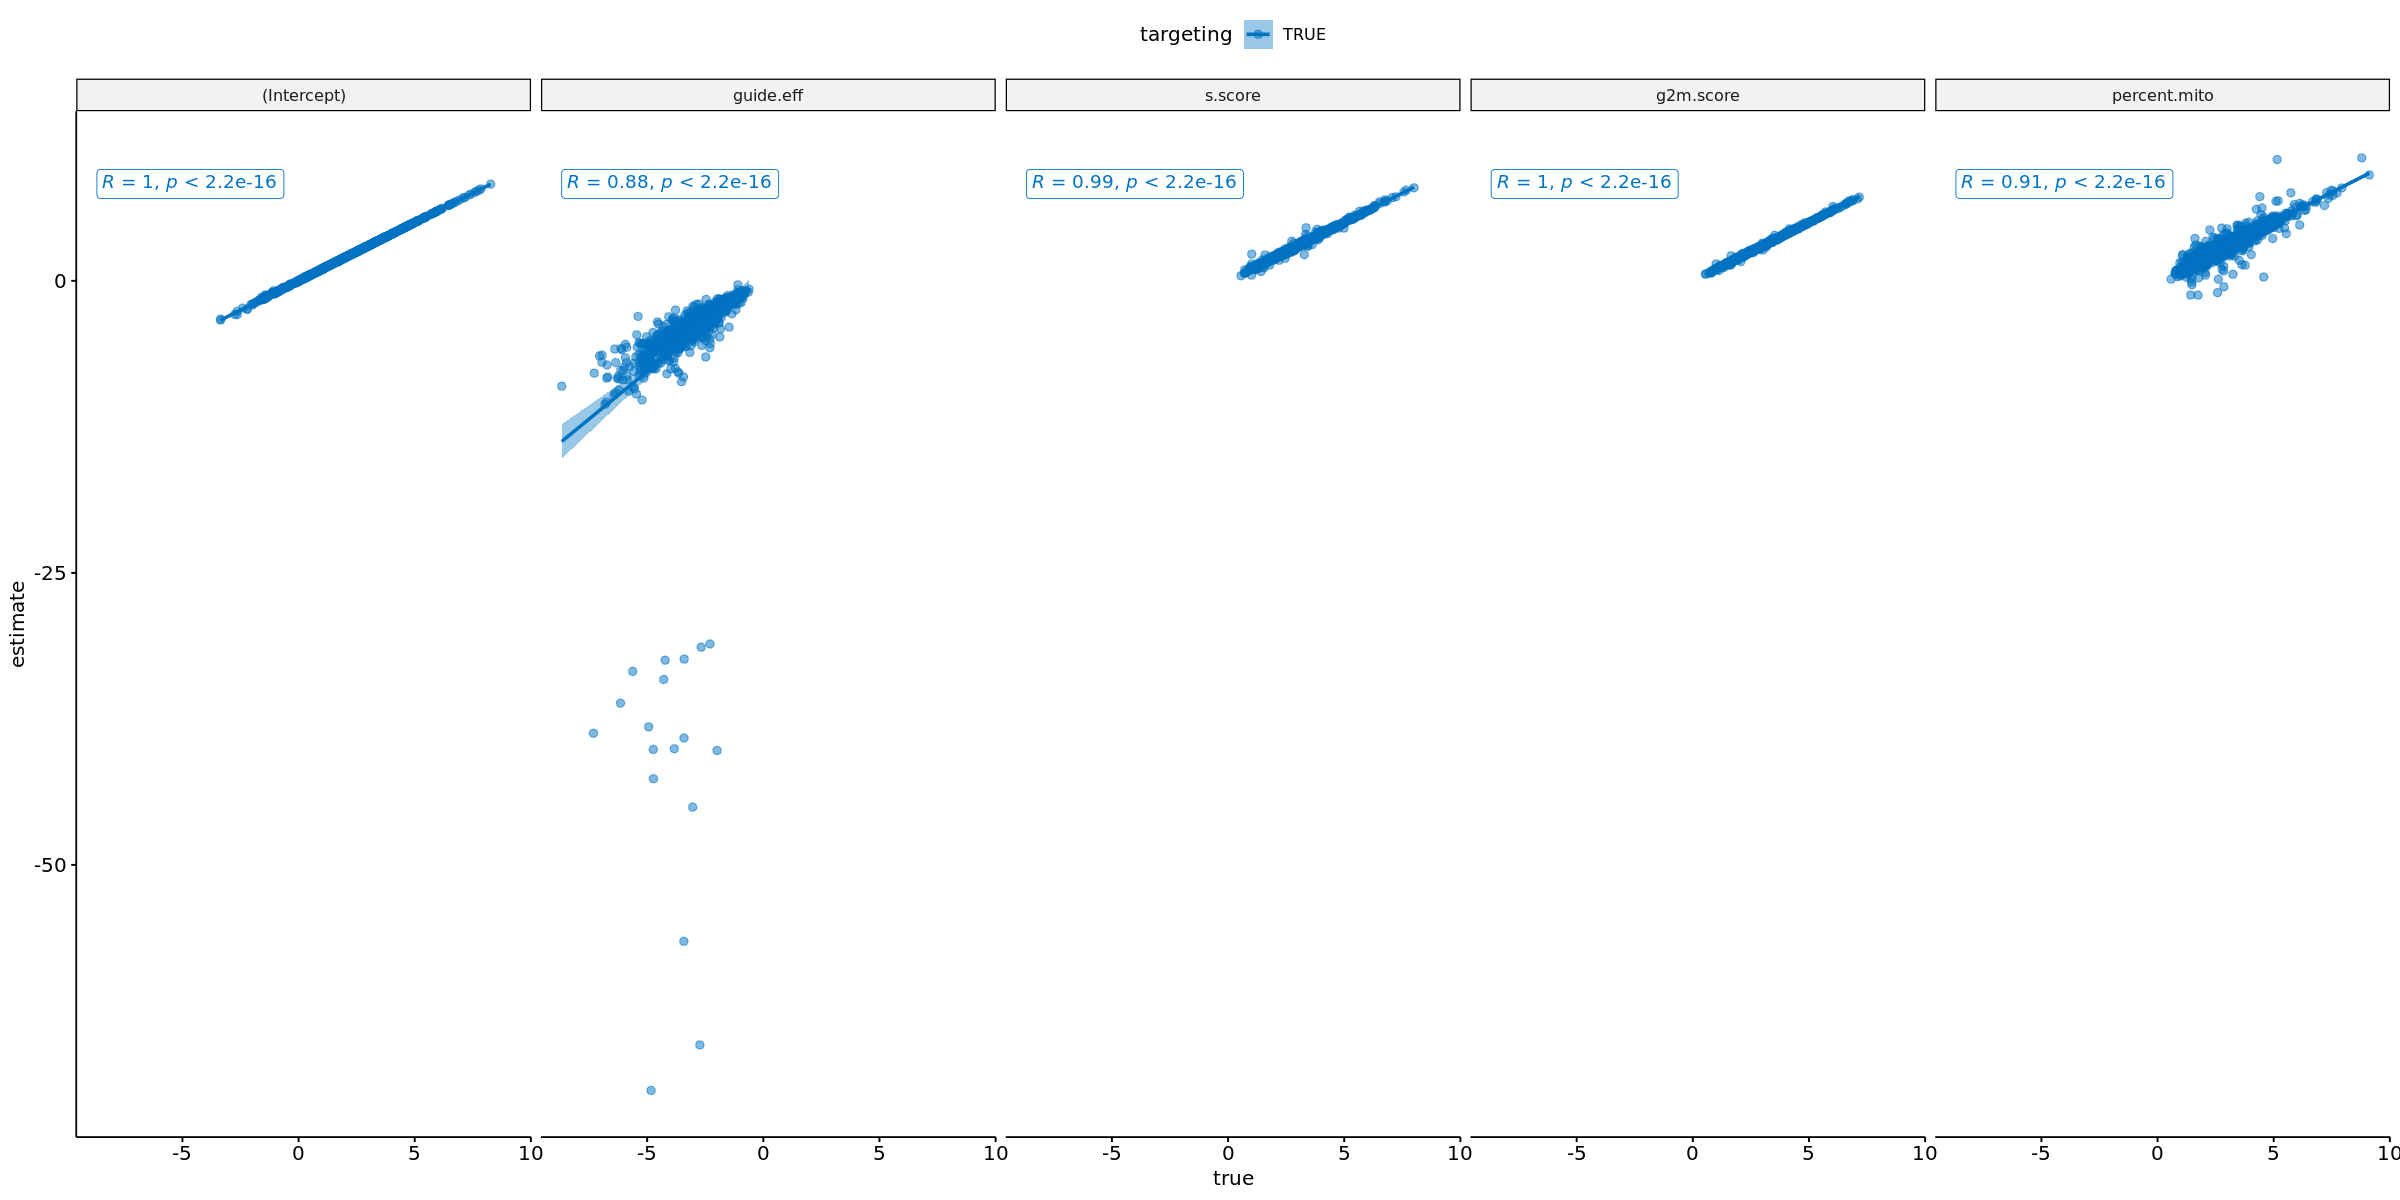

In [79]:
# labeller = labeller(term = 
#     c("(Intercept)" = expression(beta[0]),
#       "guide.eff" = expression(beta[1]),
#       "s.score" = expression(beta[2]),
#      "g2m.score" = expression(beta[3]),
#      "percent.mito" = expression(beta[4])))

coeff.names <- c("(Intercept)" = expression(beta[0]),
      "guide.eff" = expression(beta[1]),
      "s.score" = expression(beta[2]),
     "g2m.score" = expression(beta[3]),
     "percent.mito" = expression(beta[4]))

alt.coeffs %>%
   mutate(across(term, factor, levels=c("(Intercept)","guide.eff","s.score","g2m.score","percent.mito"))) %>% 
ggscatter( x = "true", y = "estimate", color = "targeting", palette = "jco", alpha = 0.5,
    
facet_wrap(~term, ncol = 5, labeller =  as_labeller(coeff.names))

In [80]:
tiff("/iblm/netapp/data1/jezhou/crisprQTL/sim_performance_D100_4guides_targeting/coeffs_scatterplot_facetwrap.tiff",
    res = 300, units = "in", width = 12, height = 6)

alt.coeffs %>%
   mutate(across(term, factor, levels=c("(Intercept)","guide.eff","s.score","g2m.score","percent.mito"))) %>% 
ggscatter( x = "true", y = "estimate", color = "targeting", palette = "jco", alpha = 0.5,
   add = "reg.line",  # Add regression line
          conf.int = TRUE
   ) + stat_cor(method = "spearman", aes(color = targeting), show.legend = FALSE, geom = "label") + 
facet_wrap(~term, ncol = 5)

dev.off()

`geom_smooth()` using formula 'y ~ x'



png 
  2

# Check that LRT is significant for targeting genes

In [68]:
intersect(alt.coeffs$gene, guides.metadata$target.gene)

[1]  4  6  7 14 24 28 44 66 77

In [69]:
for (tg in intersect(alt.coeffs$gene, guides.metadata$target.gene)) {
    print(paste("gene",tg))
    alt <- alt.mods[[tg]]
    null <- null.mods[[tg]]
    lrt <- anova(alt,null)
    print(paste("LRT p-value",lrt$`Pr(Chi)`[2]))
}

[1] "gene 4"
[1] "LRT p-value 0.00168400983985084"
[1] "gene 6"
[1] "LRT p-value 0"
[1] "gene 7"
[1] "LRT p-value 0"
[1] "gene 14"
[1] "LRT p-value 4.59139452013702e-08"
[1] "gene 24"
[1] "LRT p-value 0"
[1] "gene 28"
[1] "LRT p-value 0.0291267506681643"
[1] "gene 44"
[1] "LRT p-value 1.23268062424131e-12"
[1] "gene 66"
[1] "LRT p-value 4.73711370130303e-09"
[1] "gene 77"
[1] "LRT p-value 0.000180511305812314"


# Check that LRT is not significant for non-targeting genes

In [70]:
for (tg in setdiff(alt.coeffs$gene, guides.metadata$target.gene)) {
    print(paste("gene",tg))
    alt <- alt.mods[[tg]]
    null <- null.mods[[tg]]
    lrt <- anova(alt,null)
    pval <- lrt$`Pr(Chi)`[2]
    if (pval<0.05) {
        print('nontargeting gene has significant LRT result')
    }
}

[1] "gene 1"
[1] "nontargeting gene has significant LRT result"
[1] "gene 2"
[1] "gene 3"
[1] "gene 5"
[1] "nontargeting gene has significant LRT result"
[1] "gene 8"
[1] "gene 9"
[1] "gene 10"
[1] "gene 11"
[1] "gene 12"
[1] "nontargeting gene has significant LRT result"
[1] "gene 13"
[1] "gene 15"
[1] "gene 16"
[1] "gene 17"
[1] "gene 18"
[1] "nontargeting gene has significant LRT result"
[1] "gene 19"
[1] "gene 20"
[1] "nontargeting gene has significant LRT result"
[1] "gene 21"
[1] "gene 22"
[1] "gene 23"
[1] "gene 25"
[1] "gene 26"
[1] "gene 27"
[1] "nontargeting gene has significant LRT result"
[1] "gene 29"
[1] "gene 30"
[1] "gene 31"
[1] "gene 32"
[1] "gene 33"
[1] "nontargeting gene has significant LRT result"
[1] "gene 34"
[1] "gene 35"
[1] "gene 36"
[1] "nontargeting gene has significant LRT result"
[1] "gene 37"
[1] "gene 38"
[1] "gene 39"
[1] "gene 40"
[1] "gene 41"
[1] "nontargeting gene has significant LRT result"
[1] "gene 42"
[1] "nontargeting gene has significant LRT 

In [71]:
null.mods[[1]]


Call:  glm.nb(formula = counts ~ s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, init.theta = 2.451627559, 
    link = log)

Coefficients:
 (Intercept)       s.score     g2m.score  percent.mito  
     -0.9603        3.4518        1.6848        4.4688  

Degrees of Freedom: 49999 Total (i.e. Null);  49996 Residual
Null Deviance:	    8970 
Residual Deviance: 8614 	AIC: 11590

In [72]:
alt.mods[[1]]


Call:  glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, init.theta = 2.451627535, 
    link = log)

Coefficients:
 (Intercept)     guide.eff       s.score     g2m.score  percent.mito  
     -0.9603            NA        3.4518        1.6848        4.4688  

Degrees of Freedom: 49999 Total (i.e. Null);  49996 Residual
Null Deviance:	    8970 
Residual Deviance: 8614 	AIC: 11590

In [73]:
anova(alt.mods[[1]], null.mods[[1]])

Model,theta,Resid. df,2 x log-lik.,Test,df,LR stat.,Pr(Chi)
<chr>,<dbl>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)),2.451628,49996,-11577.77,,NA,NA,NA
s.score + g2m.score + percent.mito + offset(log(scaling.factor)),2.451628,49996,-11577.77,1 vs 2,0,2.000888e-11,0


In [74]:
summary(alt.mods[[1]])


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, init.theta = 2.451627535, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6273  -0.2456  -0.2059  -0.1737   3.8722  

Coefficients: (1 not defined because of singularities)
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.96027    0.06091  -15.77  < 2e-16 ***
guide.eff          NA         NA      NA       NA    
s.score       3.45183    0.25762   13.40  < 2e-16 ***
g2m.score     1.68477    0.12623   13.35  < 2e-16 ***
percent.mito  4.46879    1.28412    3.48 0.000501 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(2.4516) family taken to be 1)

    Null deviance: 8969.6  on 49999  degrees of freedom
Residual deviance: 8613.9  on 49996  degrees of freedom
AIC: 11588

Number of Fisher Scoring iterations: 1


              Theta: 